In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1=CPU, 0,1,...=GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 0=DEBUG, 1=INFO, 2=WARNING, 3=ERROR
np.set_printoptions(suppress=True)

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

from plot_utils import plot_feature_statistic, plot_feature_activation
from plot_utils import plot_feature_statistic_with_mask, plot_feature_activation_with_masks

In [2]:
from keras.models import Model
from keras.layers import Input, Lambda

from layers import Conv2D, DepthwiseConv2D, SparseConv2D, PartialConv2D, PartialDepthwiseConv2D
from layers import normal_init, conv_init_relu, conv_init_linear, depthwiseconv_init_relu, depthwiseconv_init_linear

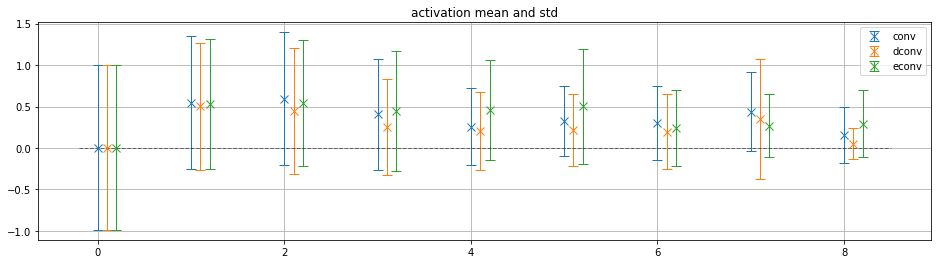

conv                      -4.636      5.383 


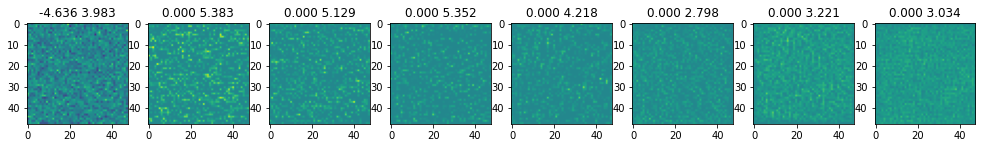

dconv                     -4.636     11.796 


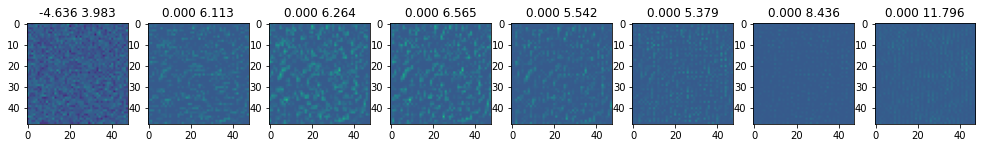

econv                     -4.636      6.417 


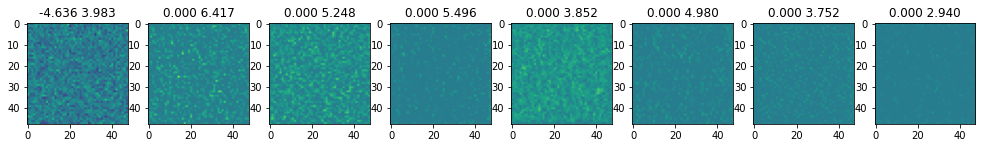

In [7]:
num_layers = 8
num_features = 16
input_shape = (48,48,8)

kwargs = {
    'kernel_size': 3,
    'strides': 1,
    'padding': 'same',
    'activation': 'relu',
    'weightnorm': False,
}

# Conv2D
x = x_in = Input(input_shape)
for i in range(num_layers):
    x = Conv2D(num_features, **kwargs, kernel_initializer=conv_init_relu)(x)
model_conv = Model(x_in, x, name='conv')

# DepthwiseConv2D
x = x_in = Input(input_shape)
for i in range(num_layers):
    x = DepthwiseConv2D(1, **kwargs, kernel_initializer=depthwiseconv_init_relu)(x)
model_dconv = Model(x_in, x, name='dconv')

# Conv2D with eaualization
x = x_in = Input(input_shape)
for i in range(num_layers):
    x = Conv2D(num_features, **kwargs, kernel_initializer=normal_init, equalize=True)(x)
model_econv = Model(x_in, x, name='econv')

x = np.ones((1,*input_shape), dtype='float32')
x = np.float32(np.random.randn(*(1,*input_shape)))
models = [model_conv, model_dconv, model_econv]

plot_feature_statistic(models, x)
plot_feature_activation(models, x)

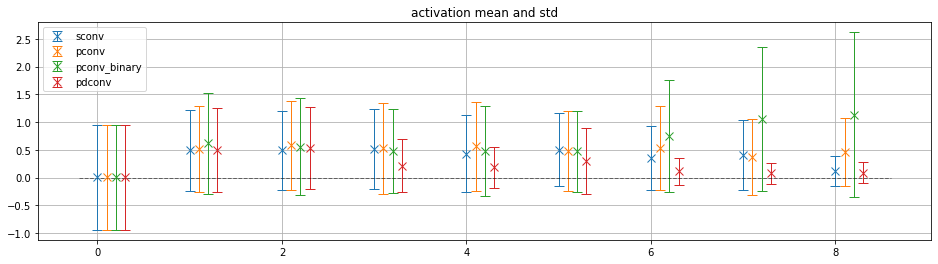

sconv                 x:     -3.602      9.302  xm:     -3.602      5.694  m:      0.000      1.000


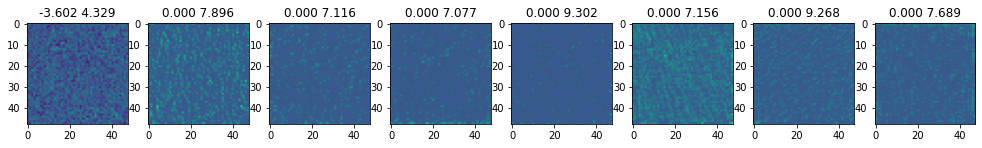

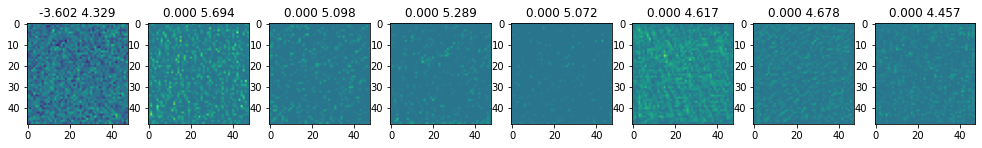

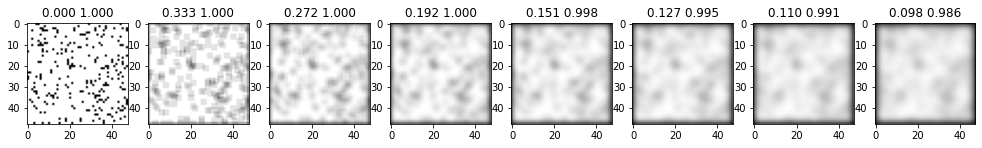

pconv                 x:     -3.602     14.008  xm:     -3.602      6.021  m:      0.000      1.000


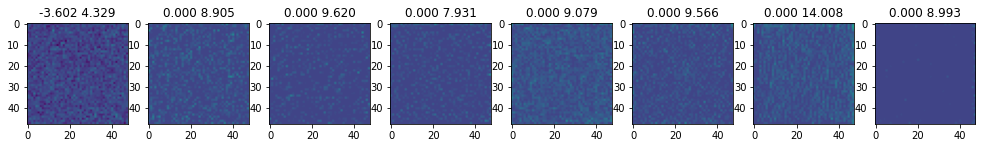

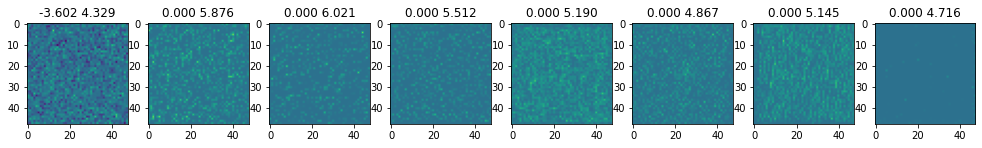

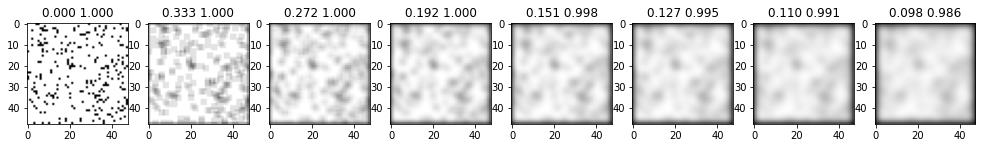

pconv_binary          x:     -3.602     25.727  xm:     -3.602     25.727  m:      0.000      1.000


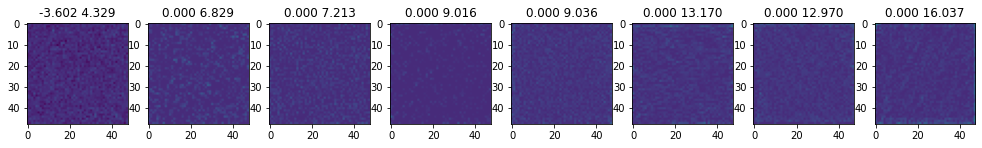

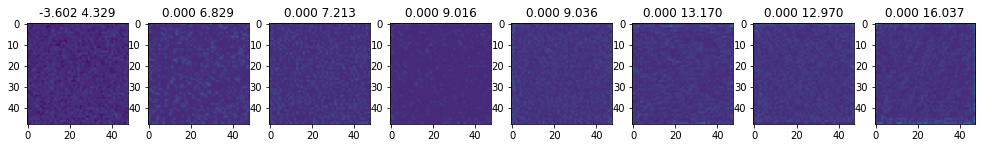

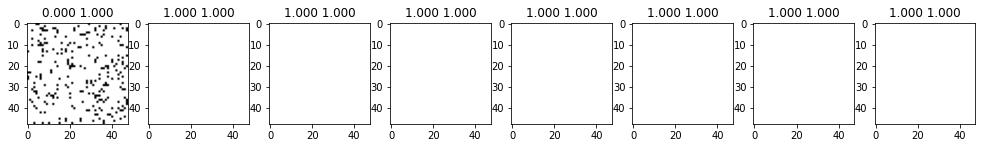

pdconv                x:     -3.602     10.206  xm:     -3.602      6.324  m:      0.000      1.000


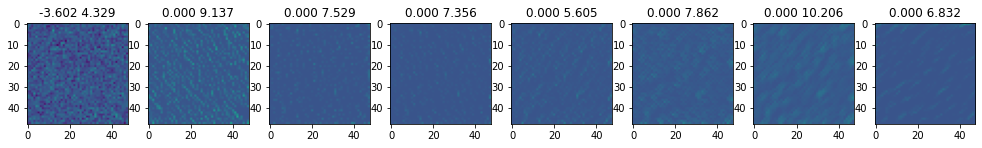

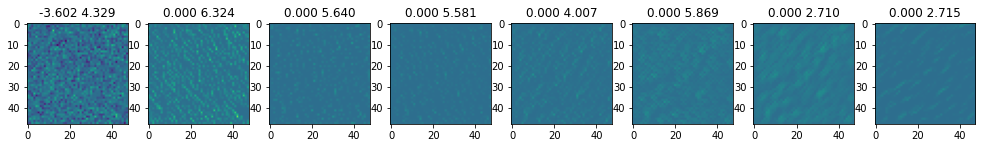

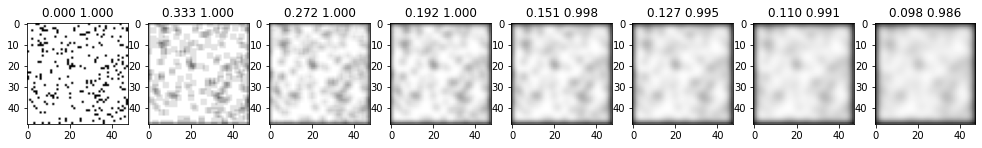

In [14]:
input_sparsity = 0.9
input_sparsity = 0.1

# SparseConv2D
xm = xm_in = [Input(input_shape), Input(input_shape)]
xm = [xm[0], Lambda(lambda x: x[...,:1])(xm[1])]
for i in range(num_layers):
    xm = SparseConv2D(num_features, **kwargs, kernel_initializer=conv_init_relu, binary=False)(xm)
model_sconv = Model(xm_in, xm, name='sconv')

# PartialConv2D
xm = xm_in = [Input(input_shape), Input(input_shape)]
for i in range(num_layers):
    xm = PartialConv2D(num_features, **kwargs, kernel_initializer=conv_init_relu, binary=False)(xm)
model_pconv = Model(xm_in, xm, name='pconv')

# PartialConv2D binary
xm = xm_in = [Input(input_shape), Input(input_shape)]
for i in range(num_layers):
    xm = PartialConv2D(num_features, **kwargs, kernel_initializer=conv_init_relu, binary=True)(xm)
model_pconv_b = Model(xm_in, xm, name='pconv_binary')

# PartialDepthwiseConv2D
xm = xm_in = [Input(input_shape), Input(input_shape)]
for i in range(num_layers):
    xm = PartialDepthwiseConv2D(1, **kwargs, kernel_initializer=depthwiseconv_init_relu, binary=False)(xm)
model_pdconv = Model(xm_in, xm, name='pdconv')

models = [model_sconv, model_pconv, model_pconv_b, model_pdconv]
#models = [model_sconv, model_pconv, model_pdconv]


x = np.ones((1,*input_shape), dtype='float32')
x = np.float32(np.random.randn(*(1,*input_shape)))
#m = np.random.binomial(1, 1-input_sparsity, size=(1,*input_shape))
m = np.repeat(np.random.binomial(1, 1-input_sparsity, size=(1,*input_shape[:-1],1)), input_shape[-1], axis=-1)

plot_feature_statistic_with_mask(models, [x,m])
plot_feature_activation_with_masks(models, [x,m])